## Driver Distraction Detection

### Name : Alyster Benedict

USN : 2KE22CS187

KLE INSTITUTE OF TECHNOLOGY,Hubballi


In [2]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from tensorflow.keras import utils 
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16





## Import the Datasets
https://www.kaggle.com/datasets/rightway11/state-farm-distracted-driver-detection/data


In [3]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset

,subject,classname,img
0,p012,c0,img_10206.jpg
1,p012,c0,img_27079.jpg
2,p012,c0,img_50749.jpg
3,p012,c0,img_97089.jpg
4,p012,c0,img_37741.jpg
...,...,...,...
34919,p075,c9,img_15827.jpg
34920,p075,c9,img_16688.jpg
34921,p075,c9,img_64532.jpg
34922,p075,c9,img_7918.jpg


From the csv file, use the `classname` as the labels for the images and use the image names to match the labels with the correct images.

#### Import Driver Dataset
This code groups the dataset by `subject` (drivers) and prints the unique driver IDs.

In [4]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p012', 'p015', 'p021', 'p022', 'p024', 'p026', 'p035', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p064', 'p066', 'p072', 'p075'])


In the following, I prepare the code to import the dataset of the driver images. then populate a few variables.

This code loads, processes, and normalizes images from a dataset for both training and testing:

- **`get_cv2_image`**: Reads and resizes images.
- **`load_train`**: Loads all training images from class-specific directories, resizing them and labeling by class.
- **`read_and_normalize_train_data`**: Splits training data into training and validation sets and reshapes them.
- **`load_test`**: Loads and resizes test images.
- **`read_and_normalize_sampled_test_data`**: Normalizes and reshapes test images.

It handles data preparation for image classification tasks.

In [5]:
# Parent directory path
parent_directory = r'C:\Users\bened\Documents\sic\imgs'

# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10

# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        directory = os.path.join(parent_directory, 'train', 'c' + str(classed))
        files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.jpg')]
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

# train data
def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = utils.to_categorical(labels, 10) # one hot encoding
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join(parent_directory, 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

#test data
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [6]:
img_rows = 64
img_cols = 64
color_type = 1

## Normalize and split the data

In [7]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:14<02:10, 14.50s/it]

Loading directory c1


 20%|██        | 2/10 [00:28<01:51, 13.91s/it]

Loading directory c2


 30%|███       | 3/10 [00:41<01:35, 13.69s/it]

Loading directory c3


 40%|████      | 4/10 [00:54<01:21, 13.58s/it]

Loading directory c4


 50%|█████     | 5/10 [01:08<01:07, 13.52s/it]

Loading directory c5


 60%|██████    | 6/10 [01:22<00:55, 13.88s/it]

Loading directory c6


 70%|███████   | 7/10 [01:37<00:42, 14.14s/it]

Loading directory c7


 80%|████████  | 8/10 [01:50<00:27, 13.67s/it]

Loading directory c8


 90%|█████████ | 9/10 [02:01<00:13, 13.02s/it]

Loading directory c9


100%|██████████| 10/10 [02:15<00:00, 13.52s/it]

Data Loaded in 135.2239592075348 second
Train shape: (13969, 64, 64, 1)
13969 train samples


In [8]:
nb_test_samples = 79726
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

100%|██████████| 4961/4961 [00:38<00:00, 130.39it/s]

Test shape: (4961, 64, 64, 1)
4961 Test samples


#### Statistics

This block of code provides statistics about the dataset, including the number of training, validation, and test images, as well as the number of categories (or classes)

In [9]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob(os.path.join(parent_directory, 'train', '*')))]
test_files_size = len(np.array(glob(os.path.join(parent_directory, 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)


There are 22423 total images.

There are 13969 training images.
There are 10 total training categories.
There are 3493 validation images.
There are 4961 test images.


In [10]:
x_train.shape

(13969, 64, 64, 1)

#### Dataset Visualization

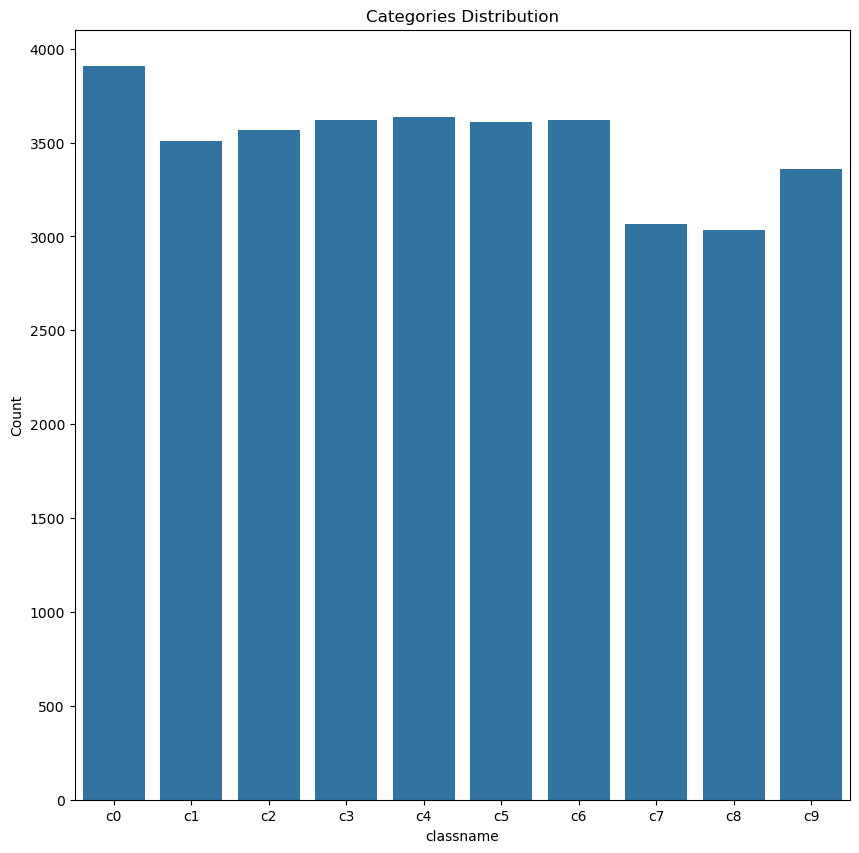

In [11]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [12]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,2474
1,p022,2466
2,p024,2452
3,p026,2392
4,p066,2068
5,p049,2022
6,p051,1840
7,p015,1750
8,p035,1696
9,p047,1670


This visualizes how many samples exist for each class

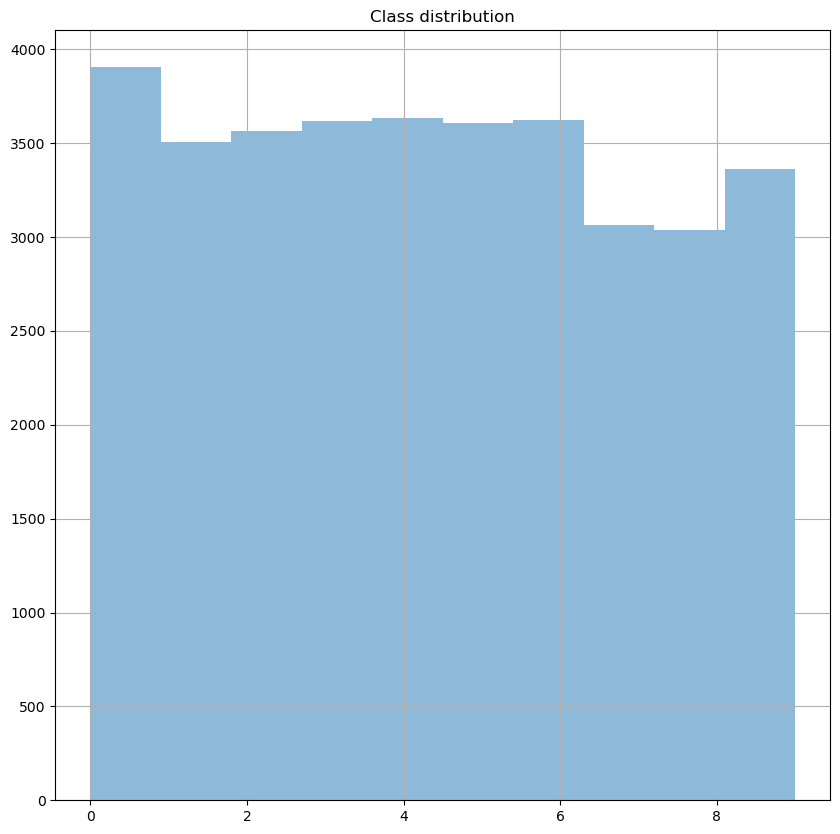

In [13]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)', expand=False).astype(float)
plt.figure(figsize=(10, 10))
dataset['class_type'].hist(alpha=0.5, bins=10)
plt.title('Class distribution')
plt.show()


#### Images overview

Let's take a look at the various images in the dataset. I'll plot an image for each of the 10 classes. As the directory names are not descriptive, I'll use a map to define the title for each image that is more descriptive.

In [14]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

This code creates a grid of images, each labeled with its corresponding class from activity_map.

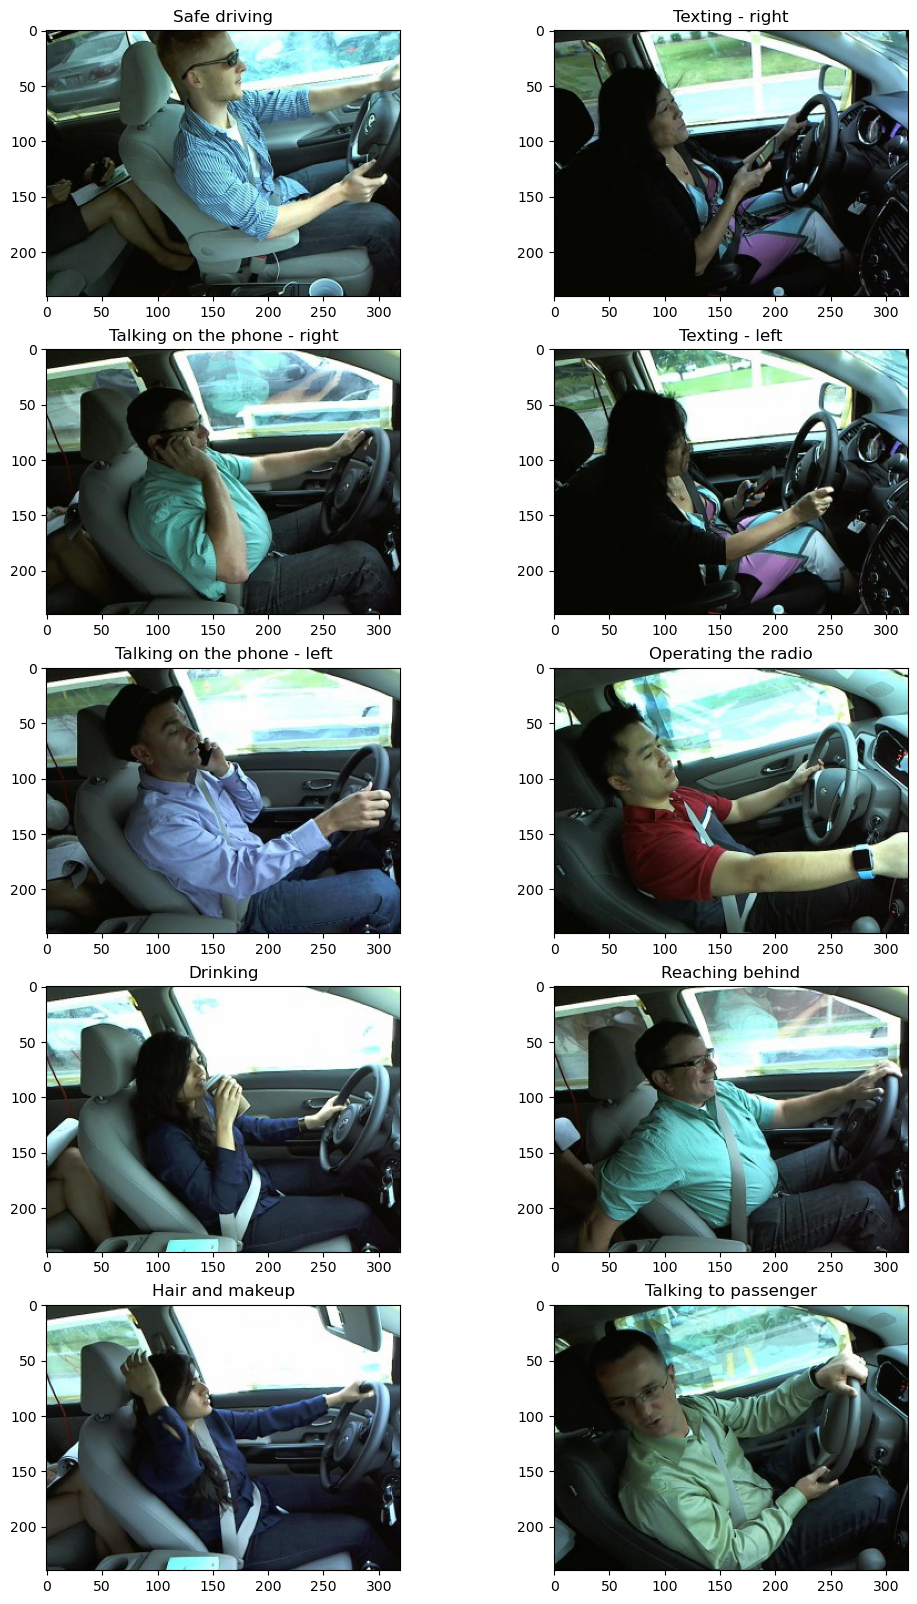

In [15]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = parent_directory + '/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

## Create a vanilla CNN model

#### Building the model

I'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers.  Optimizer `rmsprop`, and loss as `categorical_crossentropy`.

In [16]:
batch_size = 40
nb_epoch = 30

In [17]:
import os

# Remove file
if os.path.exists("saved_models/weights_best_vanilla.hdf5"):
    os.remove("saved_models/weights_best_vanilla.hdf5")
else:
    print("model does not exist")

model does not exist


In [18]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.keras', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

#### Model v1
---

This function creates a convolutional neural network model with multiple Conv2D and MaxPooling2D layers, followed by Dropout, Flatten, and Dense layers. It uses ReLU activation for hidden layers and softmax for the output layer.

`Flatten layer`: Reshapes data into a 1D vector.

`Dense layer`: Connects all neurons, enabling complex mappings and decision-making.

In [19]:
def create_model_v1():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, padding='same', kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=256, padding='same', kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=512, padding='same', kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model


In [20]:
model_v1 = create_model_v1()

model_v1.summary()

model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 256)        0

it trains the model and validates its performance using the specified parameters.

In [35]:
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)


Epoch 1/30
349/350 [============================>.] - ETA: 0s - loss: 0.2184 - accuracy: 0.9804
Epoch 1: val_loss did not improve from 0.09569
350/350 [==============================] - 38s 108ms/step - loss: 0.2183 - accuracy: 0.9804 - val_loss: 0.1401 - val_accuracy: 0.9900
Epoch 2/30
349/350 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9830
Epoch 2: val_loss did not improve from 0.09569
350/350 [==============================] - 38s 110ms/step - loss: 0.1745 - accuracy: 0.9830 - val_loss: 0.1795 - val_accuracy: 0.9917
Epoch 3/30
349/350 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9814
Epoch 3: val_loss did not improve from 0.09569
350/350 [==============================] - 38s 108ms/step - loss: 0.2361 - accuracy: 0.9815 - val_loss: 0.4799 - val_accuracy: 0.9871
Epoch 3: early stopping


Load the classifier with the best validation loss

In [22]:
model_v1.load_weights('saved_models/weights_best_vanilla.keras')

In [23]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

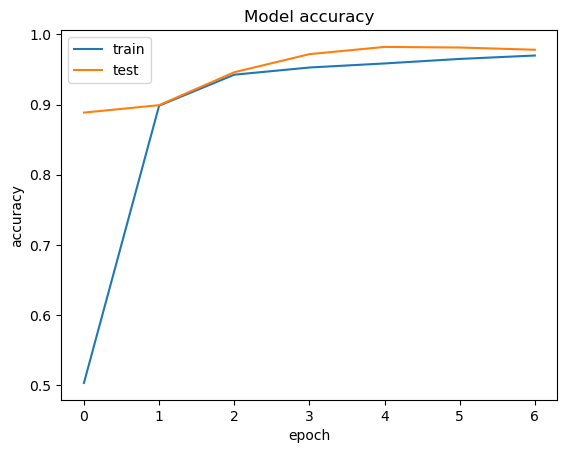

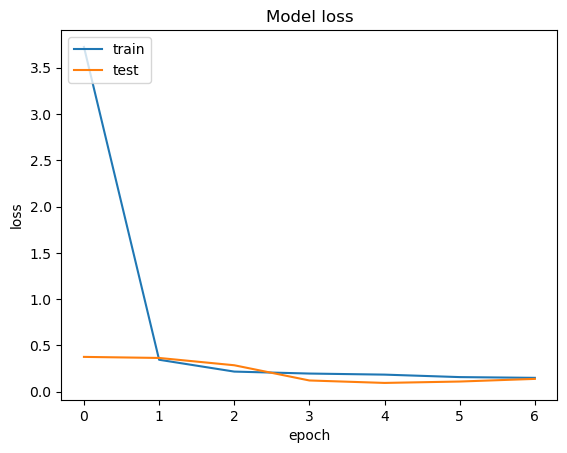

In [24]:
plot_train_history(history_v1)

This function resizes and plots a test image, then predicts its class using the model. It prints the prediction probabilities and the predicted class label.

In [25]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute, (img_rows, img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1, img_rows, img_cols, color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()


In [26]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

110/110 [==============================] - 4s 35ms/step - loss: 0.0957 - accuracy: 0.9823
Score:  [0.09568879008293152, 0.9822502136230469]


1/1 [==============================] - 0s 150ms/step
Y prediction: [[4.4437950e-37 0.0000000e+00 1.2008076e-31 0.0000000e+00 0.0000000e+00
  1.0000000e+00 1.1323139e-31 0.0000000e+00 0.0000000e+00 1.3743386e-33]]
Predicted: Operating the radio


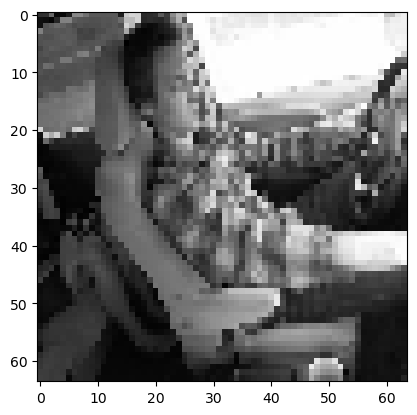

In [27]:
plot_test_class(model_v1, test_files, 1)

In [28]:
import ipywidgets as widgets
from IPython.display import display

# Function to display the predicted class for a selected test image
def on_image_selected(change):
    with output:
        output.clear_output()
        plot_test_class(model_v1, test_files, change['new'], color_type)

# Image selector slider
image_selector = widgets.IntSlider(
    value=0, min=0, max=len(test_files)-1, step=1, description='Image:', continuous_update=False
)
image_selector.observe(on_image_selected, names='value')

# Display the slider
display(image_selector)

# Output widget for displaying the plot
output = widgets.Output()
display(output)

# Initial plot
with output:
    plot_test_class(model_v1, test_files, 0, color_type)


IntSlider(value=0, continuous_update=False, description='Image:', max=4960)

Output()

save the model

In [29]:
import pickle
from tensorflow.keras.models import load_model

# Save the model
model_v1.save('model_v1.h5')

# Save preprocessing information
preprocessing = {
    'img_rows': img_rows,
    'img_cols': img_cols,
    'color_type': color_type,
    'activity_map': activity_map
}

with open('preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocessing, f)


The test 
images are processed and resized to match the model's input dimensions before making predictions.

1/1 [==============================] - 0s 24ms/step


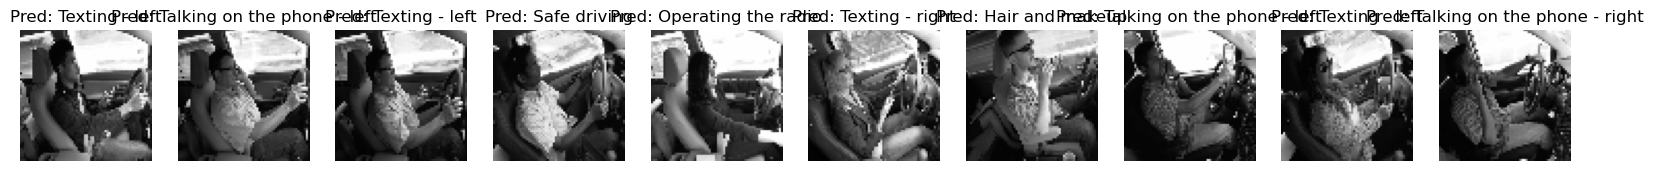

In [30]:
# Function to plot and predict multiple test images
def plot_multiple_test_images(model, test_files, img_rows, img_cols, color_type=1, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = test_files[i]
        img = cv2.resize(img, (img_rows, img_cols))
        plt.imshow(img, cmap='gray')
        img = img.reshape(-1, img_rows, img_cols, color_type)
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        predicted_label = activity_map['c' + str(predicted_class)]
        plt.title(f'Pred: {predicted_label}')
        plt.axis('off')
    plt.show()

# Test multiple images
plot_multiple_test_images(model_v1, x_test, img_rows, img_cols, color_type, num_images=10)


110/110 [==============================] - 4s 34ms/step
                              precision    recall  f1-score   support

                Safe driving       0.97      0.98      0.98       379
             Texting - right       0.98      1.00      0.99       366
Talking on the phone - right       0.99      0.99      0.99       359
              Texting - left       0.99      0.98      0.98       376
 Talking on the phone - left       0.99      0.98      0.98       366
         Operating the radio       1.00      0.98      0.99       379
                    Drinking       0.98      0.99      0.99       368
             Reaching behind       0.98      0.99      0.98       287
             Hair and makeup       0.96      0.97      0.96       294
        Talking to passenger       0.98      0.97      0.97       319

                    accuracy                           0.98      3493
                   macro avg       0.98      0.98      0.98      3493
                weighted avg    

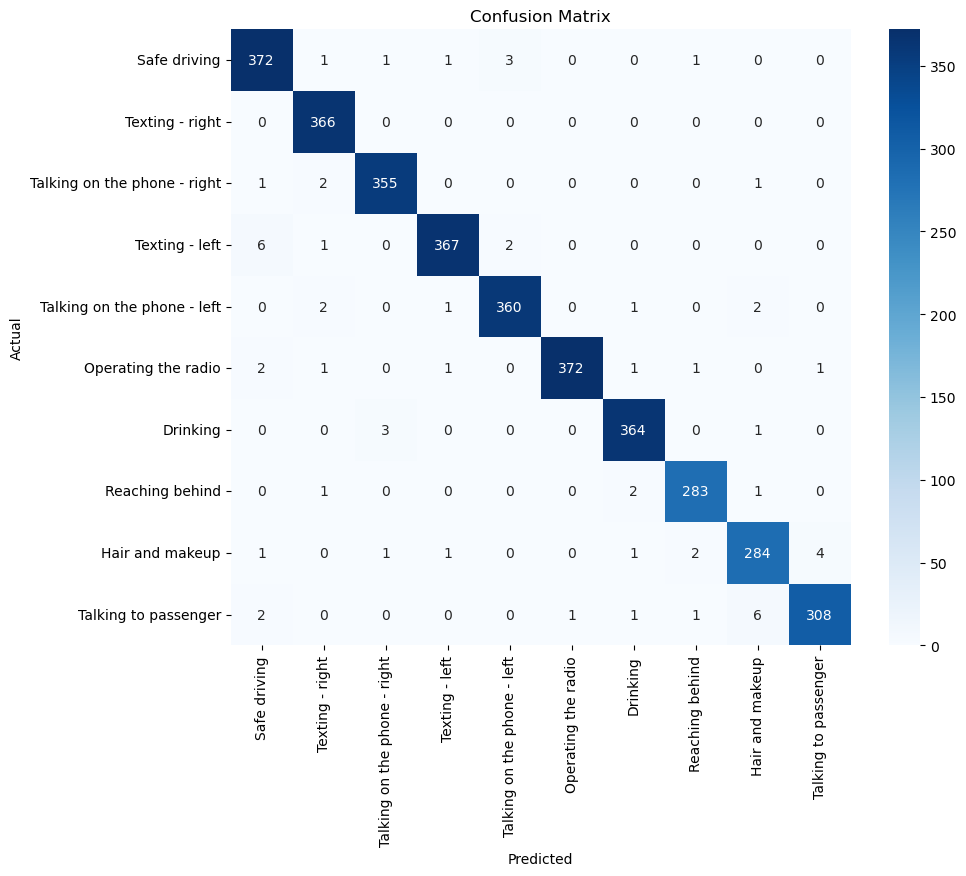

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
y_pred = model_v1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=[activity_map[f'c{i}'] for i in range(NUMBER_CLASSES)]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[activity_map[f'c{i}'] for i in range(NUMBER_CLASSES)], yticklabels=[activity_map[f'c{i}'] for i in range(NUMBER_CLASSES)])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
